In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bm=0, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.2297e-02, 2.6723e-10, 1.0948e-06, 4.1418e-12, 1.3662e-10, 8.2205e-08,
          3.0384e-13, 4.4118e-18, 1.7907e-08, 9.8770e-01]]),
 tensor([[2.6348e-01, 7.7296e-03, 4.0799e-02, 3.3591e-03, 6.7590e-03, 2.4309e-02,
          1.9921e-03, 2.1464e-04, 1.7922e-02, 6.3344e-01]]),
 tensor([[0.2458, 0.0421, 0.0967, 0.0278, 0.0394, 0.0747, 0.0214, 0.0070, 0.0641,
          0.3811]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

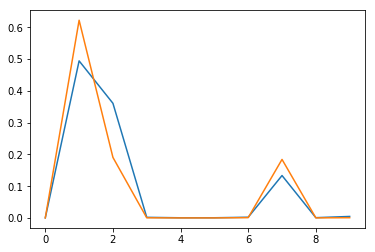

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

## Fisher

### Newton opt

In [ ]:
# export
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:
        def get_ghs(nll, p):
            g,h = calc_grad_hesse(nll, p)
            s = torch.clamp(self.lr*g.detach()/(h+1e-7), -100, 100)
            return g,h,s
        
#         alpha = torch.zeros((1,f_b_up.shape[0]), requires_grad=True, device=f_b_nom.device)
#         mu = torch.tensor([float(self.true_mu)], requires_grad=True, device=f_b_nom.device)
        alpha = torch.randn((1,f_b_up.shape[0]), requires_grad=True, device=f_b_nom.device)/10
        mu = self.true_mu+torch.randn((1), requires_grad=True, device=f_b_nom.device)/10
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        for i in range(self.n_steps):  # Newton optimise nuisances & mu
            nll = get_nll(s_exp=mu, alpha=alpha)
#             print(i, 'nll', nll.data.item(), 'mu', mu.data.item(), 'alpha',  alpha.data)
            g,h,s = get_ghs(nll,alpha)
            alpha = alpha-s
            g,h,s = get_ghs(nll,mu)
            mu = mu-s
#             print(i, 'mu hessian', h.data)
        return h
        
    def on_forwards_end(self) -> None:
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = 1/self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [ ]:
# export
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self._to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self._to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self._to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self._to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

### No opt

In [ ]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((2), requires_grad=True, device=self.wrapper.device)
        self.mu = torch.tensor([float(self.true_mu)], requires_grad=True, device=self.wrapper.device)
                
    def on_batch_begin(self) -> None: self.aug_data(self.wrapper.x)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:
        t_exp = (self.mu*f_s)+(self.true_b*f_b)
        asimov = t_exp.detach()
        p = torch.distributions.Poisson(t_exp)
        nll = -p.log_prob(asimov).sum()
        _, h_mu = calc_grad_hesse(nll, self.mu)
        _, h_a = calc_grad_hesse(nll, self.alpha)
        print('h_mu', h_mu.data, 'h_a', h_a.data)
        h = torch.cat((h_mu,h_a), 0)
        print('h_cat', h.data)
        h = torch.diag_embed(h)
        print('diag h', h.data)
        i = torch.inverse(h)
        print('inv_h', i.data, 'ikk', i[0,0], 'ihmu', 1/h_mu)
        return i[0,0]
        
    def on_forwards_end(self) -> None:
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [ ]:
class PaperInferno(AbsInferno):
    def __init__(self,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        x[:,0] += self.alpha[0]
        x[:,2] *= self.alpha[1]/3

# Test

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.Adam,lr=1e-6), loss=None,
          cbs=[PaperInferno(n_steps=10),LossTracker(),SaveBest('weights/best.h5'),EarlyStopping(5)])

h_mu tensor([0.0017], device='cuda:0') h_a tensor([107.9590,  37.5149], device='cuda:0')
h_cat tensor([1.7017e-03, 1.0796e+02, 3.7515e+01], device='cuda:0')
diag h tensor([[1.7017e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0796e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.7515e+01]], device='cuda:0')
inv_h tensor([[5.8764e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.2628e-03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.6656e-02]], device='cuda:0') ikk tensor(587.6398, device='cuda:0', grad_fn=<SelectBackward>) ihmu tensor([587.6398], device='cuda:0', grad_fn=<MulBackward0>)
h_mu tensor([0.0015], device='cuda:0') h_a tensor([109.8333,  26.9793], device='cuda:0')
h_cat tensor([1.4759e-03, 1.0983e+02, 2.6979e+01], device='cuda:0')
diag h tensor([[1.4759e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0983e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.6979e+01]], device='cuda:0')
inv_h tensor([[6.7756e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+

inv_h tensor([[6.5790e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 8.3637e-03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.1310e-02]], device='cuda:0') ikk tensor(657.9039, device='cuda:0', grad_fn=<SelectBackward>) ihmu tensor([657.9039], device='cuda:0', grad_fn=<MulBackward0>)
h_mu tensor([0.0016], device='cuda:0') h_a tensor([133.8674,  35.2874], device='cuda:0')
h_cat tensor([1.6384e-03, 1.3387e+02, 3.5287e+01], device='cuda:0')
diag h tensor([[1.6384e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.3387e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.5287e+01]], device='cuda:0')
inv_h tensor([[6.1035e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 7.4701e-03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.8339e-02]], device='cuda:0') ikk tensor(610.3488, device='cuda:0', grad_fn=<SelectBackward>) ihmu tensor([610.3488], device='cuda:0', grad_fn=<MulBackward0>)
h_mu tensor([0.0016], device='cuda:0') h_a tensor([128.9610,  38.8268], device='cuda:0')
h_cat ten

h_mu tensor([0.0015], device='cuda:0') h_a tensor([132.2560,  21.5898], device='cuda:0')
h_cat tensor([1.4825e-03, 1.3226e+02, 2.1590e+01], device='cuda:0')
diag h tensor([[1.4825e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.3226e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.1590e+01]], device='cuda:0')
inv_h tensor([[6.7455e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 7.5611e-03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.6318e-02]], device='cuda:0') ikk tensor(674.5451, device='cuda:0', grad_fn=<SelectBackward>) ihmu tensor([674.5451], device='cuda:0', grad_fn=<MulBackward0>)
h_mu tensor([0.0016], device='cuda:0') h_a tensor([145.6692,  16.8317], device='cuda:0')
h_cat tensor([1.6080e-03, 1.4567e+02, 1.6832e+01], device='cuda:0')
diag h tensor([[1.6080e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.4567e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.6832e+01]], device='cuda:0')
inv_h tensor([[6.2190e+02, 0.0000e+00, 0.0000e+00],
        [0.0000e+

KeyboardInterrupt: 

In [ ]:
model.load('weights/best.h5')

In [ ]:
model.save('weights/Inferno_Test.h5')

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
model = ModelWrapper(net)
model.load('weights/Inferno_Test.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [ ]:
preds = model.predict(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,3,1.0
2,3,1.0
3,3,1.0
4,2,1.0


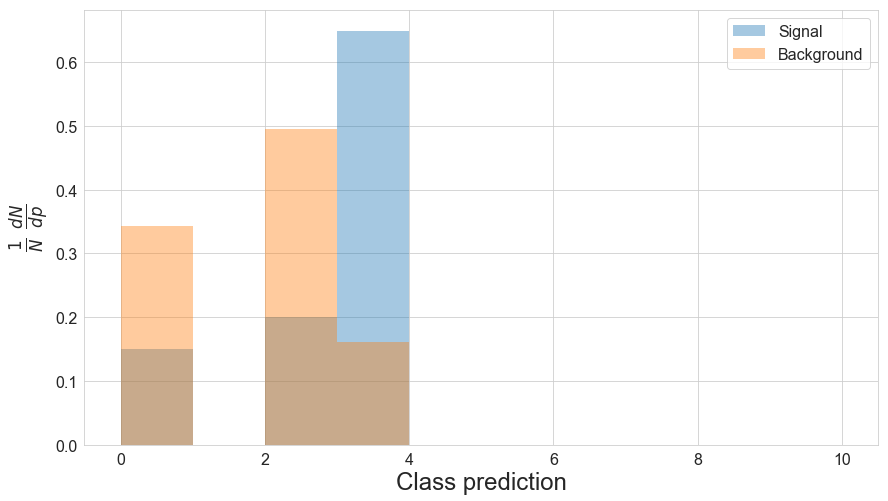

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0,1.0,0
1,3,1.0,3
2,3,1.0,3
3,3,1.0,3
4,2,1.0,2


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([1.4974e-01, 2.0076e-01, 6.4950e-01, 2.0000e-13, 2.0000e-13, 2.0000e-13,
         2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13]),
 tensor([3.4333e-01, 4.9477e-01, 1.6189e-01, 2.0000e-13, 2.0000e-13, 2.0000e-13,
         2.0000e-13, 2.0000e-13, 2.0000e-13, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([3.5082e+02, 5.0481e+02, 1.9437e+02, 2.1000e-10, 2.1000e-10, 2.1000e-10,
         2.1000e-10, 2.1000e-10, 2.1000e-10, 2.1000e-10]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([12.54730225, 12.47229004, 12.39953613, 12.32952881, 12.26287842,
       12.1987915 , 12.13726807, 12.07861328, 12.02215576, 11.96881104,
       11.91827393, 11.87005615, 11.824646  , 11.78179932, 11.74139404,
       11.70391846, 11.66851807, 11.63604736, 11.60571289, 11.578125  ,
       11.55303955, 11.53045654, 11.5100708 , 11.49243164, 11.47717285,
       11.46417236, 11.45349121, 11.44512939, 11.43933105, 11.43579102,
       11.43487549, 11.43603516, 11.43951416, 11.44512939, 11.45300293,
       11.46374512, 11.47576904, 11.49066162, 11.5078125 , 11.52679443,
       11.54815674, 11.57202148, 11.59710693, 11.62506104, 11.6552124 ,
       11.68713379, 11.72113037, 11.75799561, 11.79602051, 11.83660889,
       11.87896729, 11.92358398, 11.97039795, 12.019104  , 12.06976318,
       12.12231445, 12.17645264, 12.23345947, 12.29187012, 12.35247803,
       12.41485596])

In [ ]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [ ]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

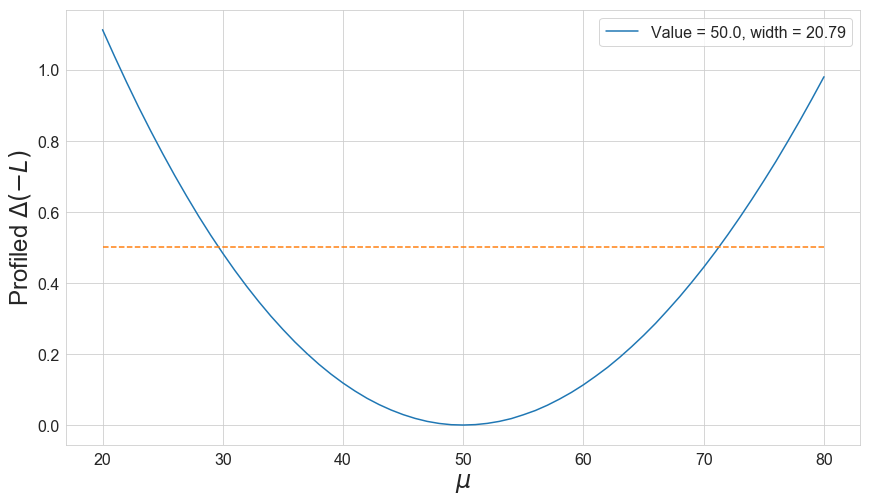

In [ ]:
plot_likelihood(y-y.min())

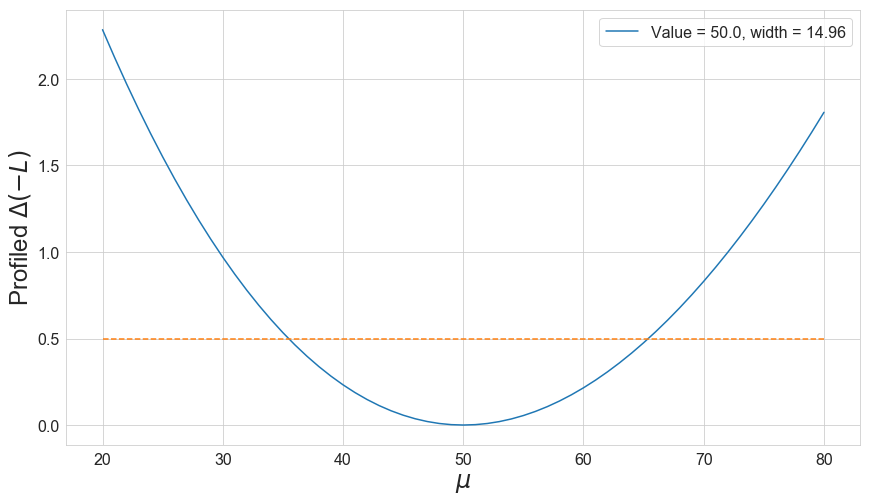

In [ ]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,4,1.0,4,4,4,4,4,4,4,4,4,4,4
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,8,1.0,8,8,8,8,8,8,8,8,8,8,8
3,3,1.0,3,3,3,3,3,3,3,3,3,3,3
4,1,1.0,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999996,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999997,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999998,1,0.0,1,1,1,1,1,1,1,1,1,1,1


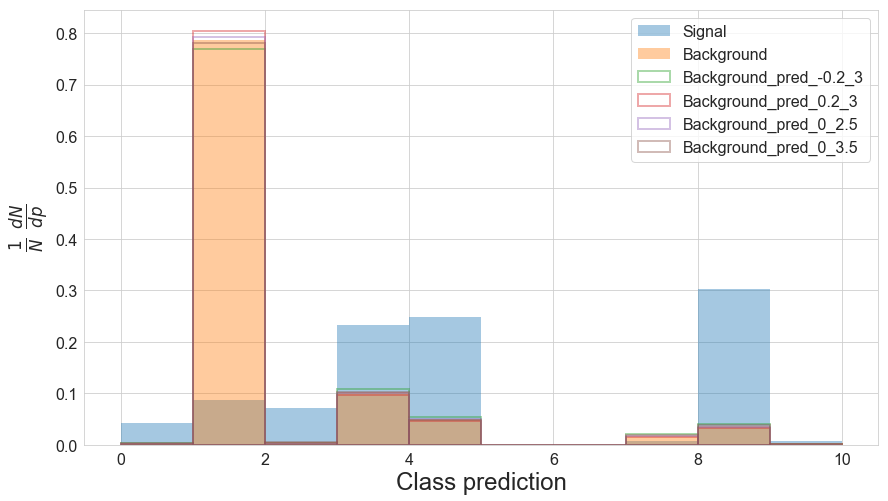

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([7.7674e-01, 2.4540e-03, 1.0775e-01, 5.4676e-02, 2.0000e-13, 2.0000e-13,
        2.0448e-02, 3.7338e-02, 5.9000e-04, 2.0000e-13])
tensor([7.7196e-01, 3.6920e-03, 1.0863e-01, 5.3870e-02, 2.0000e-13, 2.0000e-13,
        2.1088e-02, 3.9564e-02, 1.1940e-03, 2.0000e-13])
tensor([7.6737e-01, 5.3000e-03, 1.0936e-01, 5.2886e-02, 2.0000e-13, 2.0000e-13,
        2.1768e-02, 4.1296e-02, 2.0240e-03, 2.0000e-13])
tensor([7.9465e-01, 2.1800e-03, 1.0134e-01, 5.0578e-02, 2.0000e-13, 2.0000e-13,
        1.6836e-02, 3.3912e-02, 4.9600e-04, 2.0000e-13])
tensor([7.8987e-01, 3.4180e-03, 1.0222e-01, 4.9772e-02, 2.0000e-13, 2.0000e-13,
        1.7476e-02, 3.6138e-02, 1.1000e-03, 2.0000e-13])
tensor([7.8528e-01, 5.0260e-03, 1.0295e-01, 4.8788e-02, 2.0000e-13, 2.0000e-13,
        1.8156e-02, 3.7870e-02, 1.9300e-03, 2.0000e-13])
tensor([8.1203e-01, 1.9980e-03, 9.4956e-02, 4.6236e-02, 2.0000e-13, 2.0000e-13,
        1.3762e-02, 3.0628e-02, 3.9000e-04, 2.0000e-13])
tensor([8.0725e-01, 3.2360e-03, 9.5836e-0

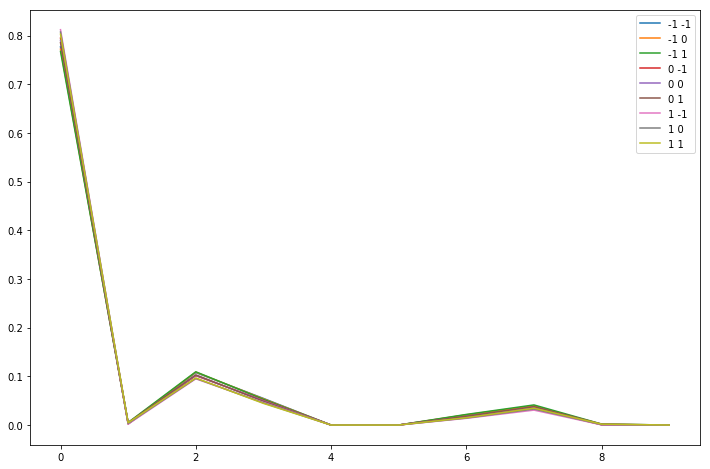

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll,_ = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

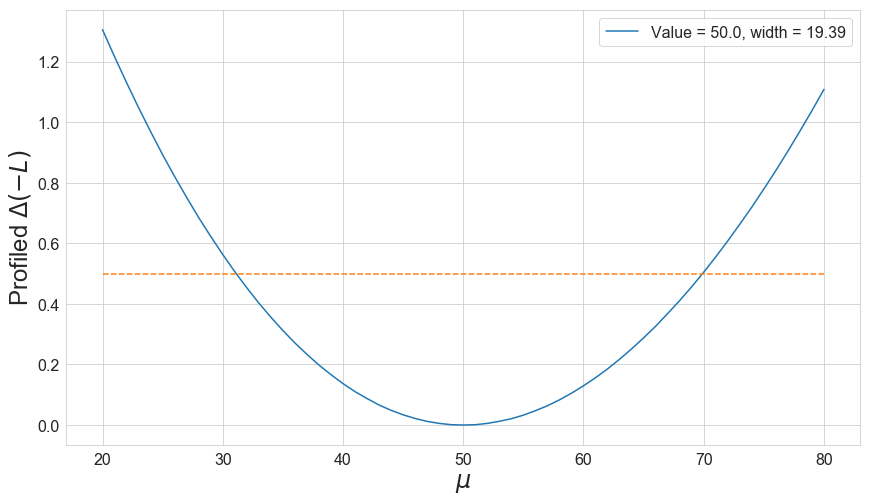

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll,_ = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

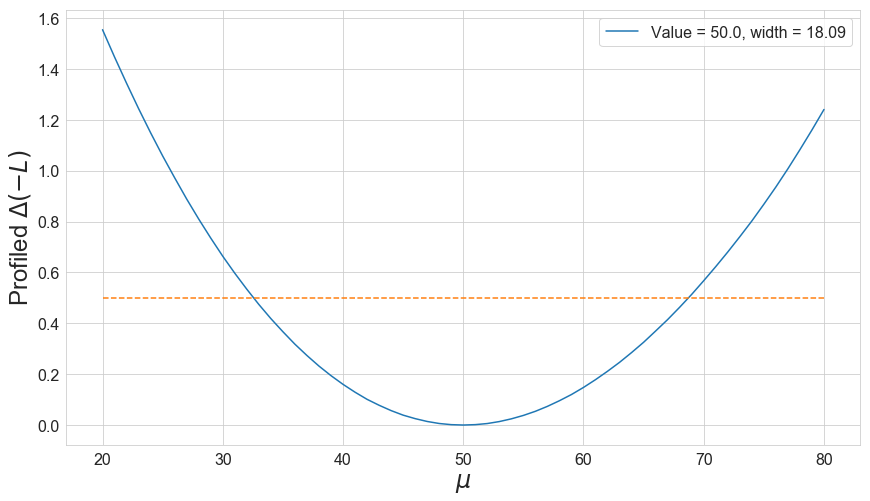

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll,_ = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

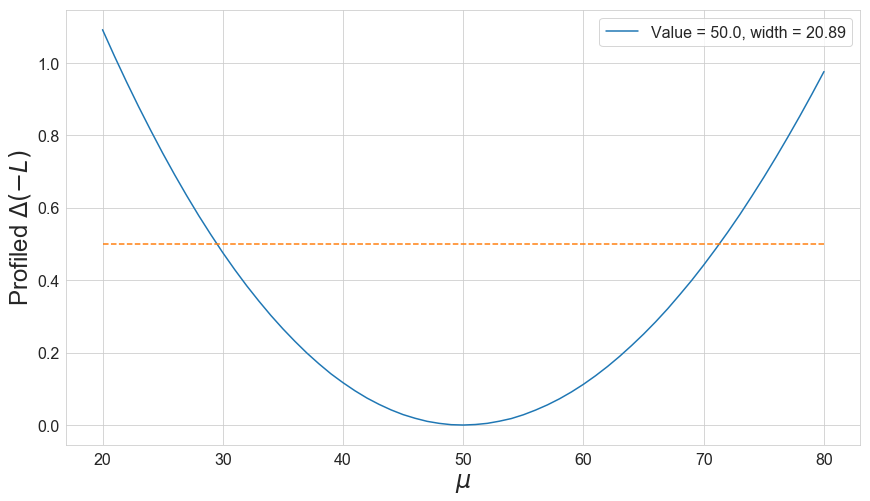

In [ ]:
plot_likelihood(nll-nll.min())